In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('/Users/costa/Repositories/max_pred_states_repo+data/maximally_predictive_states/utils')
import operator_calculations as op_calc
import stats

In [3]:
#change path to where 'manuscript_data' is saved
dir_path = '/Users/costa/Repositories/max_pred_states_repo+data/manuscript_data/'

In [16]:
from lmfit import minimize, Parameters, Parameter, report_fit

def fcn2min(params,x,data,weights):
    m=params['m'].value
    b=params['b'].value
    return np.sqrt(weights)*(m/x + b - data)

def bootstrap_estimate(h_source_K_N,kN,n_samples,K_min=None,K_max=None):
    if K_min==None:
        K_min=0
    if K_max==None:
        K_max = h_source_K_N.shape[0]
    params = Parameters()
    params.add('m',   value= 1)
    params.add('b', value= 1,min=0)
    mean = h_source_K_N[K_min:K_max,kN,:].mean(axis=1)
    std = h_source_K_N[K_min:K_max,kN,:].std(axis=1)
    cil = np.percentile(h_source_K_N[K_min:K_max,kN,:],2.5,axis=1)
    ciu = np.percentile(h_source_K_N[K_min:K_max,kN,:],97.5,axis=1)

    x = K_range[K_min:K_max]*dt
    data = mean
    weigths = 1/std**2
    result = minimize(fcn2min, params, args=(x,data,weigths))
    
    h_inf = result.params['b'].value
    bs = np.zeros(n_samples)
    ms = np.zeros(n_samples)
    for k in range(n_samples):
        sample_indices = np.random.randint(0,h_source_K_N.shape[2],h_source_K_N.shape[2])
        params = Parameters()
        params.add('m',   value= 1)
        params.add('b', value= 1,min=0)
        mean = h_source_K_N[K_min:K_max,kN,sample_indices].mean(axis=1)
        std = h_source_K_N[K_min:K_max,kN,sample_indices].std(axis=1)

        x = K_range[K_min:K_max]*dt
        data = mean
        weigths = 1/std**2
        result = minimize(fcn2min, params, args=(x,data,weigths))
        b = result.params['b'].value
        m = result.params['m'].value
        bs[k]=b
        ms[k]=m
    return h_inf,np.percentile(bs,2.5),np.percentile(bs,97.5),ms,bs

# FigS7b

## Lorenz chaos 

In [19]:
f = h5py.File(dir_path+'KS_entropy/Lorenz/combined_entropy_results.h5','r')
h_K_N = np.array(f['h_source'])
h_x_K_N = np.array(f['h_source_x'])
h_embed_K_N = np.array(f['h_embed'])
K_range = np.array(f['K_range'],dtype=int)
cluster_range = np.array(f['cluster_range'],dtype=int)
T = np.array(f['T'],dtype=int)[0]
dt = np.array(f['dt'])[0]
f.close()

f = h5py.File(dir_path+'KS_entropy/Lorenz/combined_lyap_results.h5','r')
L = np.array(f['L'])
LE = np.array(f['LE'])
LEs = np.array(f['LEs'])
f.close()

h_lyap_Lorenz=np.array([LE.mean(axis=0)[0],np.percentile(LE,2.5,axis=0)[0],np.percentile(LE,97.5,axis=0)[0]])

h_source_K_N = (h_K_N.T/(K_range*dt)).T
h_source_max_K = (h_K_N.max(axis=1).T/(K_range*dt)).T
kN=4
K_min=0
K_max=9
n_samples=100
h,h_cil,h_ciu,ms,bs= bootstrap_estimate(h_source_K_N,kN,n_samples,K_min=K_min,K_max=K_max)
h_Lorenz = np.hstack([h,h_cil,h_ciu])

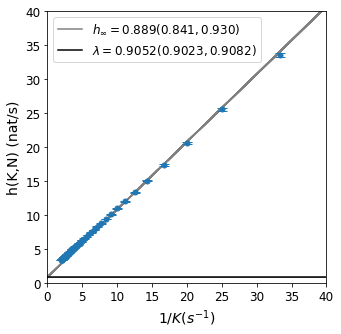

In [22]:
plt.figure(figsize=(5,5))
xplot = np.linspace(0,1/(K_range[0]*dt))
for k in range(len(ms)):
    plt.plot(xplot,ms[k]*xplot+bs[k],c='gray',alpha=.1)
plt.plot(xplot,ms.mean()*(xplot)+bs.mean(),c='gray',alpha=1,label='$h_\infty = {:.3f}({:.3f},{:.3f})$'.format(h,h_cil,h_ciu))
plt.errorbar(1/(K_range*dt),h_source_K_N[:,kN,:].mean(axis=1),yerr = h_source_K_N[:,kN,:].std(axis=1),marker='o',ms=5,capsize=5,fmt='o')

plt.axhline(h_lyap_Lorenz[0],c='k',label='$\lambda = {:.4f}({:.4f},{:.4f})$'.format(h_lyap_Lorenz[0],h_lyap_Lorenz[1],h_lyap_Lorenz[2]))
plt.axhspan(h_lyap_Lorenz[1],h_lyap_Lorenz[2],color='k',alpha=.5)
# plt.ylim(0,2)
# plt.xlim(0,2)
plt.xlabel('$1/K (s^{-1})$',fontsize=14)
plt.ylabel('h(K,N) (nat/s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,40)
# plt.ylim(0,40)
plt.ylim(0,40)
# plt.savefig('h_1_K_infty_zoom.pdf')
plt.show()

## Rossler 

In [24]:
#Rossler results
f = h5py.File(dir_path+'KS_entropy/Rossler/combined_entropy_results.h5','r')
h_K_N = np.array(f['h_source'])
h_x_K_N = np.array(f['h_source_x'])
h_embed_K_N = np.array(f['h_embed'])
K_range = np.array(f['K_range'],dtype=int)
cluster_range = np.array(f['cluster_range'],dtype=int)
print(cluster_range.shape)
T = np.array(f['T'],dtype=int)[0]
dt = np.array(f['dt'])[0]
f.close()

f = h5py.File(dir_path+'KS_entropy/Rossler/combined_lyap_results.h5','r')
L = np.array(f['L'])
LE = np.array(f['LE'])
LEs = np.array(f['LEs'])
f.close()

h_lyap_Rossler=np.array([LE.mean(axis=0)[0],np.percentile(LE,2.5,axis=0)[0],np.percentile(LE,97.5,axis=0)[0]])

h_source_K_N = (h_K_N.T/(K_range*dt)).T
h_source_max_K = (h_K_N.max(axis=1).T/(K_range*dt)).T
K_min=0
K_max=30
kN=3
n_samples=100
h,h_cil,h_ciu,ms,bs = bootstrap_estimate(h_source_K_N,kN,n_samples,K_min=K_min,K_max=K_max)
h_Rossler = np.hstack([h,h_cil,h_ciu])

(6,)


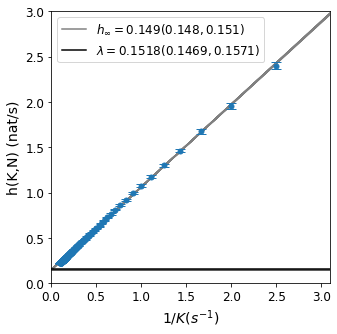

In [25]:
plt.figure(figsize=(5,5))
xplot = np.linspace(0,1/(K_range[0]*dt))
for k in range(len(ms)):
    plt.plot(xplot,ms[k]*xplot+bs[k],c='gray',alpha=.1)
plt.plot(xplot,ms.mean()*(xplot)+bs.mean(),c='gray',alpha=1,label='$h_\infty = {:.3f}({:.3f},{:.3f})$'.format(h,h_cil,h_ciu))
plt.errorbar(1/(K_range*dt),h_source_K_N[:,kN,:].mean(axis=1),yerr = h_source_K_N[:,kN,:].std(axis=1),marker='o',ms=5,capsize=5,fmt='o')

plt.axhline(h_lyap_Rossler[0],c='k',label='$\lambda = {:.4f}({:.4f},{:.4f})$'.format(h_lyap_Rossler[0],h_lyap_Rossler[1],h_lyap_Rossler[2]))
plt.axhspan(h_lyap_Rossler[1],h_lyap_Rossler[2],color='k',alpha=.5)
# plt.ylim(0,2)
# plt.xlim(0,2)
plt.xlabel('$1/K (s^{-1})$',fontsize=14)
plt.ylabel('h(K,N) (nat/s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0,3)
plt.xlim(0,3.1)
# plt.savefig('h_1_K_infty_zoom.pdf')
plt.show()

## Lorenz limit cycle 

In [26]:
#Lorenz limit cycle results
f = h5py.File(dir_path+'KS_entropy/Lorenz_limit_cycle/combined_entropy_results.h5','r')
h_K_N = np.array(f['h_source'])
h_x_K_N = np.array(f['h_source_x'])
h_embed_K_N = np.array(f['h_embed'])
K_range = np.array(f['K_range'],dtype=int)
cluster_range = np.array(f['cluster_range'],dtype=int)
T = np.array(f['T'],dtype=int)[0]
dt = np.array(f['dt'])[0]
f.close()

f = h5py.File(dir_path+'KS_entropy/Lorenz_limit_cycle/combined_lyap_results.h5','r')
L = np.array(f['L'])
LE = np.array(f['LE'])
LEs = np.array(f['LEs'])
f.close()

h_lyap_Lorenz_limit_cycle=np.array([LE.mean(axis=0)[0],np.percentile(LE,2.5,axis=0)[0],np.percentile(LE,97.5,axis=0)[0]])

h_source_K_N = (h_K_N.T/(K_range*dt)).T
h_source_max_K = (h_K_N.max(axis=1).T/(K_range*dt)).T
K_min=0
K_max=20
kN=2
n_samples=100
h,h_cil,h_ciu,ms,bs = bootstrap_estimate(h_source_K_N,kN,n_samples,K_min=K_min,K_max=K_max)
h_Lorenz_limit_cycle = np.hstack([h,h_cil,h_ciu])

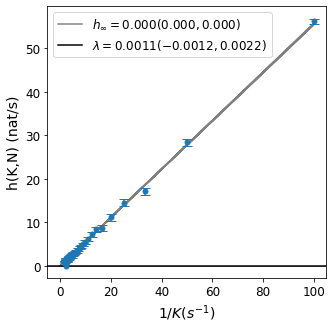

In [30]:
plt.figure(figsize=(5,5))
xplot = np.linspace(0,1/(K_range[0]*dt))
for k in range(len(ms)):
    plt.plot(xplot,ms[k]*xplot+bs[k],c='gray',alpha=.1)
plt.plot(xplot,ms.mean()*(xplot)+bs.mean(),c='gray',alpha=1,label='$h_\infty = {:.3f}({:.3f},{:.3f})$'.format(h,h_cil,h_ciu))
plt.errorbar(1/(K_range*dt),h_source_K_N[:,kN,:].mean(axis=1),yerr = h_source_K_N[:,kN,:].std(axis=1),marker='o',ms=5,capsize=5,fmt='o')

plt.axhline(h_lyap_Lorenz_limit_cycle[0],c='k',label='$\lambda = {:.4f}({:.4f},{:.4f})$'.format(h_lyap_Lorenz_limit_cycle[0],h_lyap_Lorenz_limit_cycle[1],h_lyap_Lorenz_limit_cycle[2]))
plt.axhspan(h_lyap_Lorenz_limit_cycle[1],h_lyap_Lorenz_limit_cycle[2],color='k',alpha=.5)
# plt.ylim(0,2)
# plt.xlim(0,2)
plt.xlabel('$1/K (s^{-1})$',fontsize=14)
plt.ylabel('h(K,N) (nat/s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
# plt.ylim(0,3)
# plt.xlim(0,3.1)
# plt.savefig('h_1_K_infty_zoom.pdf')
plt.show()

## C elegans 

In [32]:
frameRate=16.
dt=1/frameRate

K_range = np.arange(1,100)
worm_range = np.arange(12)
cluster_range = np.array(np.logspace(1,3.5,8),dtype=int)
h_w_x_K = np.zeros((len(K_range),len(cluster_range),len(worm_range)))
h_w_embed_K = np.zeros((len(K_range),len(cluster_range),len(worm_range)))
for worm_idx in worm_range:
    for k,K in enumerate(K_range):
        f = h5py.File(dir_path+'KS_entropy/Celegans/h_worm_{}_K_{}.h5'.format(worm_idx,K),'r')
        h_source_x = np.array(f['h_source_x'])
        h_embed = np.array(f['h_embed'])
        mD = f['MetaData']
        K = np.array(mD['K'])[0]
        cluster_range = np.array(mD['cluster_range'])
        f.close()
        h_w_x_K[k,:,worm_idx] = h_source_x
        h_w_embed_K[k,:,worm_idx] = h_embed
    print(worm_idx)
    
h_source_K_N = (h_w_x_K.T/(K_range*dt)).T


h_lyap_Foraging = np.array([1,0.93,1.09]) #from Ahamed et al.

K_min=0
K_max=22
kN=5
n_samples=100
h,h_cil,h_ciu,ms,bs = bootstrap_estimate(h_source_K_N,kN,n_samples,K_min,K_max)
h_Foraging = np.hstack([h,h_cil,h_ciu])

0
1
2
3
4
5
6
7
8
9
10
11


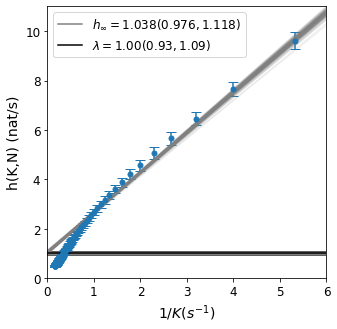

In [36]:
plt.figure(figsize=(5,5))
plt.errorbar(1/(K_range*dt),h_source_K_N[:,kN,:].mean(axis=1),yerr = h_source_K_N[:,kN,:].std(axis=1),marker='o',ms=5,capsize=5,fmt='o')

xplot = np.linspace(0,1/(K_range[0]*dt))
for k in range(len(ms)):
    plt.plot(xplot,ms[k]*xplot+bs[k],c='gray',alpha=.1)
plt.plot(xplot,ms.mean()*(xplot)+bs.mean(),c='gray',alpha=1,label='$h_\infty = {:.3f}({:.3f},{:.3f})$'.format(h,h_cil,h_ciu))
plt.xlabel('$1/K (s^{-1})$',fontsize=14)
plt.ylabel('h(K,N) (nat/s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,6)
plt.ylim(0,11)
plt.axhline(h_lyap_Foraging[0],c='k',label='$\lambda = {:.2f}({:.2f},{:.2f})$'.format(h_lyap_Foraging[0],h_lyap_Foraging[1],h_lyap_Foraging[2]))
plt.axhspan(h_lyap_Foraging[1],h_lyap_Foraging[2],color='k',alpha=.5)
plt.legend(fontsize=12)

# plt.savefig('h_1_K_infty_0_22_zoom.pdf')
plt.show()

In [37]:
#Henon results
f = h5py.File(dir_path+'KS_entropy/Henon/combined_entropy_results.h5','r')
h_K_N = np.array(f['h_source'])
h_x_K_N = np.array(f['h_source_x'])
h_embed_K_N = np.array(f['h_embed'])
K_range = np.array(f['K_range'],dtype=int)
cluster_range = np.array(f['cluster_range'],dtype=int)
n_iters = np.array(f['n_iters'],dtype=int)[0]
f.close()

f = h5py.File(dir_path+'KS_entropy/Henon/combined_lyap_results.h5','r')
lyaps = np.array(f['LE'])
f.close()
lyaps = np.concatenate(lyaps,axis=0)
h_lyap_Henon=np.array([lyaps.mean(axis=0)[1],np.percentile(lyaps,2.5,axis=0)[1],np.percentile(lyaps,97.5,axis=0)[1]])

kN=2
mean_diff = -((np.diff((h_K_N.T/K_range)[:,kN,:],axis=1))/np.diff(K_range)).mean(axis=0)
idx=np.argmin(mean_diff)
h_Henon = np.array([(h_K_N.T/K_range)[:,kN,idx].mean(),np.percentile((h_K_N.T/K_range)[:,kN,idx],2.5,axis=0),np.percentile((h_K_N.T/K_range)[:,kN,idx],97.5,axis=0)])

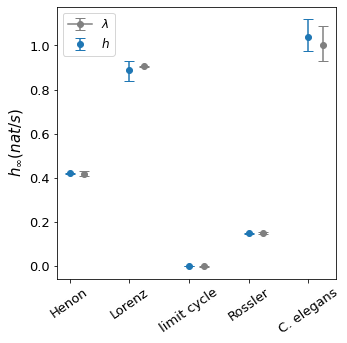

In [38]:
plt.figure(figsize=(5,5))
plt.errorbar(0.25,h_lyap_Henon[0],yerr =[[h_lyap_Henon[0]-h_lyap_Henon[1]],[h_lyap_Henon[2]-h_lyap_Henon[0]]],c='gray',marker='o',capsize=5)
plt.errorbar(1.25,h_lyap_Lorenz[0],yerr =[[h_lyap_Lorenz[0]-h_lyap_Lorenz[1]],[h_lyap_Lorenz[2]-h_lyap_Lorenz[0]]],c='gray',marker='o',capsize=5)
plt.errorbar(2.25,h_lyap_Lorenz_limit_cycle[0],yerr =[[h_lyap_Lorenz_limit_cycle[0]-h_lyap_Lorenz_limit_cycle[1]],[h_lyap_Lorenz_limit_cycle[2]-h_lyap_Lorenz_limit_cycle[0]]],c='gray',marker='o',capsize=5)
plt.errorbar(3.25,h_lyap_Rossler[0],yerr =[[h_lyap_Rossler[0]-h_lyap_Rossler[1]],[h_lyap_Rossler[2]-h_lyap_Rossler[0]]],c='gray',marker='o',capsize=5)
plt.errorbar(4.25,h_lyap_Foraging[0],yerr =[[h_lyap_Foraging[0]-h_lyap_Foraging[1]],[h_lyap_Foraging[2]-h_lyap_Foraging[0]]],c='gray',marker='o',capsize=5,label='$\lambda$')
mean = np.hstack([h_Henon[0],h_Lorenz[0],h_Lorenz_limit_cycle[0],h_Rossler[0],h_Foraging[0]])
cil = np.hstack([h_Henon[1],h_Lorenz[1],h_Lorenz_limit_cycle[1],h_Rossler[1],h_Foraging[1]])
ciu = np.hstack([h_Henon[2],h_Lorenz[2],h_Lorenz_limit_cycle[2],h_Rossler[2],h_Foraging[2]])

plt.errorbar(np.arange(0,5),mean,yerr = [mean-cil,ciu-mean],capsize=5,fmt='o',label='$h$')
# plt.ylim(-.05,1)
plt.xticks([0,1,2,3,4],['Henon','Lorenz','limit cycle','Rossler','C. elegans'],rotation=35,fontsize=13)
plt.ylabel('$h_\infty (nat/s)$',fontsize=15)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
# plt.savefig('h_infs_5_systems.pdf')
plt.show()